In [4]:
import os
import urllib.request
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("Movie_Recommendation_Engine").getOrCreate()


files = {
    "ratings.csv": "https://raw.githubusercontent.com/khanhnamle1994/movielens/master/ratings.csv",
    "movies.csv": "https://raw.githubusercontent.com/khanhnamle1994/movielens/master/movies.csv"
}

for name, url in files.items():
    if not os.path.exists(name):
        print(f"Downloading {name}... ⏳")
        urllib.request.urlretrieve(url, name)
        print(f"{name} Downloaded! ")



ratings_df = spark.read.option("delimiter", "\t").csv("ratings.csv", header=True, inferSchema=True)
movies_df = spark.read.option("delimiter", "\t").csv("movies.csv", header=True, inferSchema=True)


print("--- Ratings Data  ---")
ratings_df.select("user_id", "movie_id", "rating").show(5)

print("--- Movies Data  ---")
movies_df.select("movie_id", "title", "genres").show(5)

--- Ratings Data  ---
+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|      1|    1193|     5|
|      1|     661|     3|
|      1|     914|     3|
|      1|    3408|     4|
|      1|    2355|     5|
+-------+--------+------+
only showing top 5 rows
--- Movies Data  ---
+--------+--------------------+--------------------+
|movie_id|               title|              genres|
+--------+--------------------+--------------------+
|       1|    Toy Story (1995)|Animation|Childre...|
|       2|      Jumanji (1995)|Adventure|Childre...|
|       3|Grumpier Old Men ...|      Comedy|Romance|
|       4|Waiting to Exhale...|        Comedy|Drama|
|       5|Father of the Bri...|              Comedy|
+--------+--------------------+--------------------+
only showing top 5 rows


In [5]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col


ratings_df = spark.read.option("delimiter", "\t").csv("ratings.csv", header=True, inferSchema=True)
movies_df = spark.read.option("delimiter", "\t").csv("movies.csv", header=True, inferSchema=True)


ratings_df = ratings_df.withColumn("user_id", col("user_id").cast("integer")) \
                       .withColumn("movie_id", col("movie_id").cast("integer")) \
                       .withColumn("rating", col("rating").cast("float"))

(training_data, test_data) = ratings_df.randomSplit([0.8, 0.2])

print("Training the Model...  ⏳")


als = ALS(maxIter=5,
          regParam=0.01,
          userCol="user_id",
          itemCol="movie_id",
          ratingCol="rating",
          coldStartStrategy="drop")


model = als.fit(training_data)

print("Model Trained Successfully! ")


predictions = model.transform(test_data)
predictions.select("user_id", "movie_id", "rating", "prediction").show(5)

Training the Model...  ⏳
Model Trained Successfully! 
+-------+--------+------+----------+
|user_id|movie_id|rating|prediction|
+-------+--------+------+----------+
|    148|     648|   2.0| 3.9071584|
|    148|     575|   4.0| 4.0735736|
|    148|     577|   4.0|  3.405099|
|    148|    3930|   3.0| 3.2321632|
|    148|    1320|   5.0|  3.199182|
+-------+--------+------+----------+
only showing top 5 rows


In [6]:
from pyspark.sql.functions import explode


user_recs = model.recommendForAllUsers(5)


my_user_recs = user_recs.filter(col("user_id") == 148)


my_user_recs = my_user_recs.withColumn("rec", explode("recommendations")) \
                           .select("user_id", col("rec.movie_id"), col("rec.rating"))


final_recs = my_user_recs.join(movies_df, "movie_id", "inner") \
                         .select("movie_id", "title", "genres", "rating") \
                         .orderBy("rating", ascending=False)


print("--- Top 5 Movie Recommendations for User 148 ---")
final_recs.show(truncate=False)

--- Top 5 Movie Recommendations for User 148 ---
+--------+--------------------------------------+----------------+---------+
|movie_id|title                                 |genres          |rating   |
+--------+--------------------------------------+----------------+---------+
|2219    |Murder! (1930)                        |Mystery|Thriller|6.3461533|
|572     |Foreign Student (1994)                |Drama           |6.174495 |
|2388    |Steam: The Turkish Bath (Hamam) (1997)|Drama|Romance   |5.9017015|
|598     |Window to Paris (1994)                |Comedy          |5.8034377|
|1871    |Friend of the Deceased, A (1997)      |Comedy|Drama    |5.5576096|
+--------+--------------------------------------+----------------+---------+



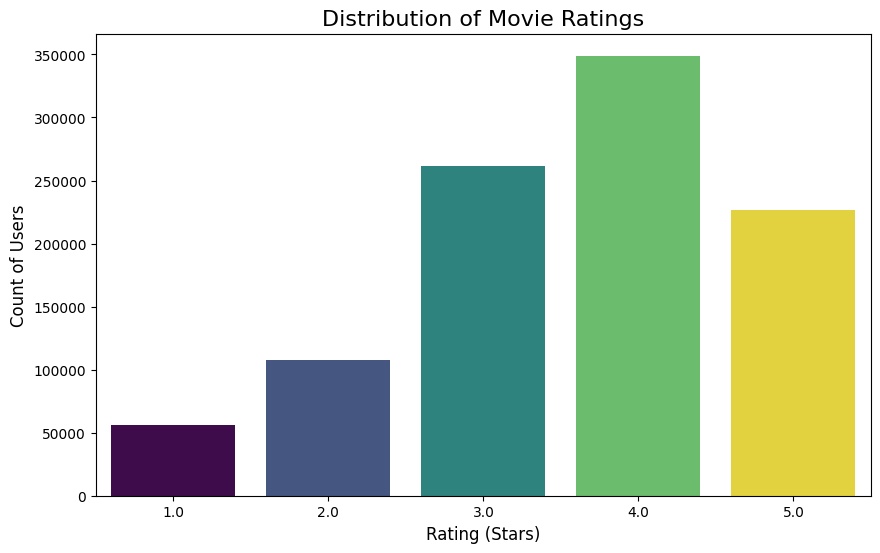

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

rating_counts = ratings_df.groupBy("rating").count().orderBy("rating")

pdf_ratings = rating_counts.toPandas()


plt.figure(figsize=(10, 6))

sns.barplot(x='rating', y='count', data=pdf_ratings, hue='rating', palette='viridis', legend=False)

plt.title('Distribution of Movie Ratings', fontsize=16)
plt.xlabel('Rating (Stars)', fontsize=12)
plt.ylabel('Count of Users', fontsize=12)
plt.show()

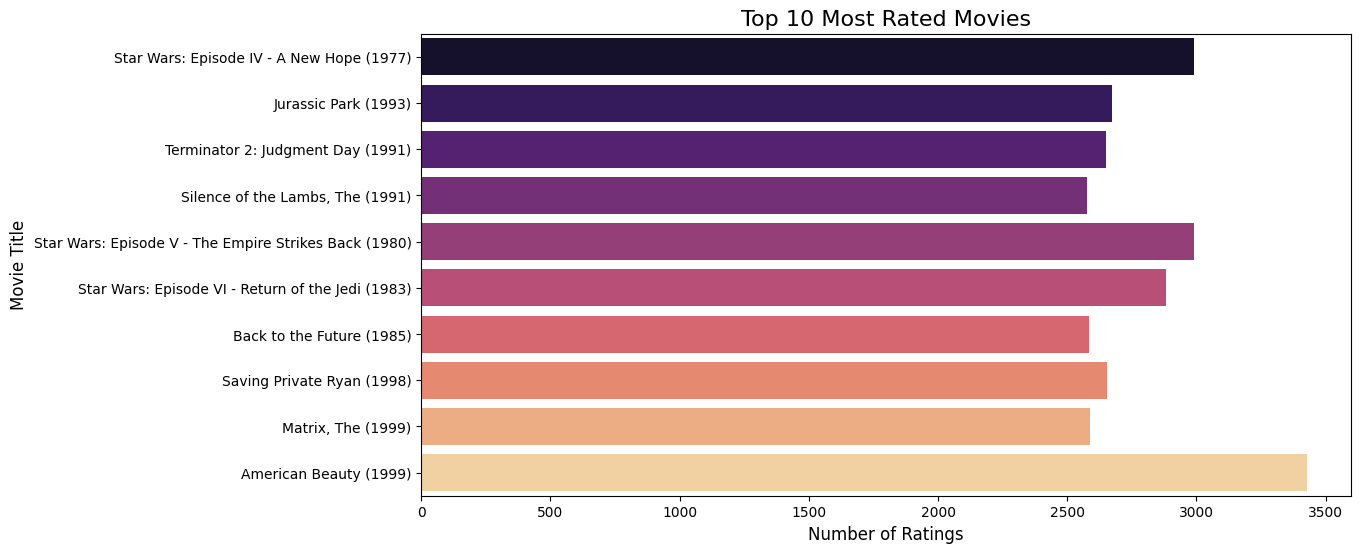

In [9]:

popular_movies = ratings_df.groupBy("movie_id").count().orderBy("count", ascending=False).limit(10)
top_movies = popular_movies.join(movies_df, "movie_id").select("title", "count")
pdf_top = top_movies.toPandas()

plt.figure(figsize=(12, 6))

sns.barplot(x='count', y='title', data=pdf_top, hue='title', palette='magma', legend=False)

plt.title('Top 10 Most Rated Movies', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.show()

In [10]:

ratings_df.createOrReplaceTempView("ratings")
movies_df.createOrReplaceTempView("movies")

complex_query = """
    SELECT
        m.genres,
        ROUND(AVG(r.rating), 2) as avg_rating,
        COUNT(r.rating) as rating_count
    FROM movies m
    JOIN ratings r ON m.movie_id = r.movie_id
    GROUP BY m.genres
    HAVING rating_count > 100
    ORDER BY avg_rating DESC
    LIMIT 5
"""


sql_result = spark.sql(complex_query)

print("--- Top Genres by Average Rating (SQL Analysis) ---")
sql_result.show(truncate=False)

--- Top Genres by Average Rating (SQL Analysis) ---
+-------------------------+----------+------------+
|genres                   |avg_rating|rating_count|
+-------------------------+----------+------------+
|Animation|Comedy|Thriller|4.47      |688         |
|Sci-Fi|War               |4.45      |1367        |
|Animation                |4.39      |459         |
|Film-Noir|Mystery        |4.37      |1584        |
|Adventure|War            |4.35      |1644        |
+-------------------------+----------+------------+

